In [1]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine
raw_engine = author.raw_engine

각 종목 별로 유의미한 피쳐들을 선정해 사용한다. </br>
* BTC: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d, Rsi
* TLT: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d
* QQQ: Macd_signal, Vwap, pct, Moment, Rsi, Macd_Gap
* GCF: Macd_signal, Vwap, pct, Moment

* Vix나 USDT 같은 지표 들은 그냥 값을 그대로 활용했다. 부가적인 요소들을 사용하지 않았다.

In [2]:
def get_df(ticker):
    df = pd.read_sql(f"SELECT * FROM {ticker}_1d",engine) #로컬 db에서 테이블 가져옴
    df.set_index(df.columns[0], inplace=True)
    return df

bit_df = get_df("BTCUSD")
qqq_df = get_df("QQQ")
tlt_df = get_df("TLT")
gld_df = get_df("GCF")


비트코인의 데이터 만으로 가격을 예측 할 수 있을까? </br>
비트코인은 다른 자산과의 상관관계도 높은 편이고 과적합을 피하기 위해서라도 다른 자산의 피쳐를 활용하는 것은 </br>
현명한 생각으로 보여진다.

In [3]:
bit_fedf = bit_df[["Macd_Signal", "Vwap", "Pct", "Moment", "Fast_d", "Rsi","Price"]]
tlt_fedf = tlt_df[["Moment"]]
qqq_fedf = qqq_df[["Moment"]]
gld_fedf = gld_df[["Moment"]]

금, 미국 장기채, 나스닥, 금선물의 추세지표를 가져온다.

In [4]:
vix = pd.read_sql("SELECT Date, Close FROM VIX_1d", raw_engine)
vix.set_index(vix.columns[0], inplace=True)
usd = pd.read_sql("SELECT Date, Close FROM DXF_1d", raw_engine)
usd.set_index(usd.columns[0], inplace=True)


VIX(변동성 지표)와 달러 인덱스도 가져온다.

In [5]:
data_frames = [bit_fedf, tlt_fedf, qqq_fedf, gld_fedf, vix, usd]
for df, ticker in zip(data_frames, ["BTC","TLT","QQQ","GCF","VIX","USD"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [26]:
from functools import reduce
df_merged = reduce(lambda left,right: pd.merge(left, right, right_index=True, left_index=True,
                                            how='inner'), data_frames)

df_merged

,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,BTC_Price,TLT_Moment,QQQ_Moment,GCF_Moment,VIX_Close,USD_Close
2015-11-11,22.953,270.309,-7.641,1.091,6.247,46.116,311.084,0.979,1.045,0.948,16.059999,99.157997
2015-11-12,20.278,270.823,8.701,1.136,8.413,52.819,338.152,0.981,1.040,0.946,18.370001,98.711998
2015-11-13,17.839,271.171,-0.414,1.130,7.438,52.455,336.753,0.983,1.030,0.946,20.080000,99.097000
2015-11-16,10.614,271.938,3.306,1.107,5.277,50.911,330.751,0.982,1.038,0.947,18.160000,99.538002
2015-11-17,9.495,272.266,1.313,1.103,4.457,52.099,335.094,0.983,1.039,0.940,18.840000,99.699997
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,1695.200,27587.314,-3.238,69.607,5.786,60.159,45538.676,1.091,2.318,1.315,20.559999,98.360001
2022-04-01,1683.290,27604.237,1.632,70.123,12.297,62.470,46281.645,1.093,2.316,1.307,19.629999,98.626999
2022-04-04,1581.457,27643.927,0.364,71.793,12.747,62.867,46622.676,1.089,2.325,1.310,18.570000,98.973999
2022-04-05,1462.346,27657.210,-2.288,72.156,8.558,57.075,45555.992,1.078,2.313,1.309,21.030001,99.428001


모델을 학습 시켜보자. 자산을 추가함으로써 내가 얻고 싶은 것들은 아래와 같다.
* 모델의 과적합 해소
* 모델이 폭락, 폭등에 조금이나마 적응
* 특정 기간에만 잘 맞는 현상 제거

In [27]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=1,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=1,random_state=42,fit_intercept=True))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=1,random_state=42,fit_intercept=True,l1_ratio=0.8))
])

In [28]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['BTC_Price'], axis=1).iloc[1:]
    y = df['BTC_Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [29]:
train_X, test_X, train_y, test_y = create_train_data(df_merged)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=1, l1_ratio=0.8, random_state=42))])

In [30]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar(figsize=(12,8))

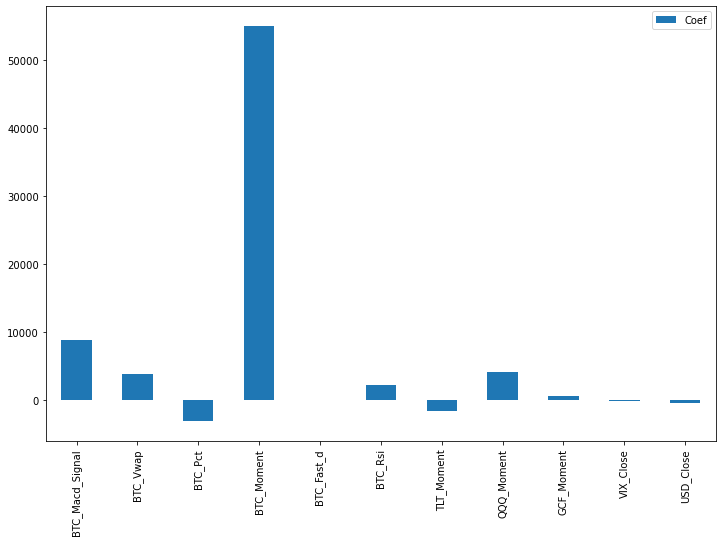

In [31]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

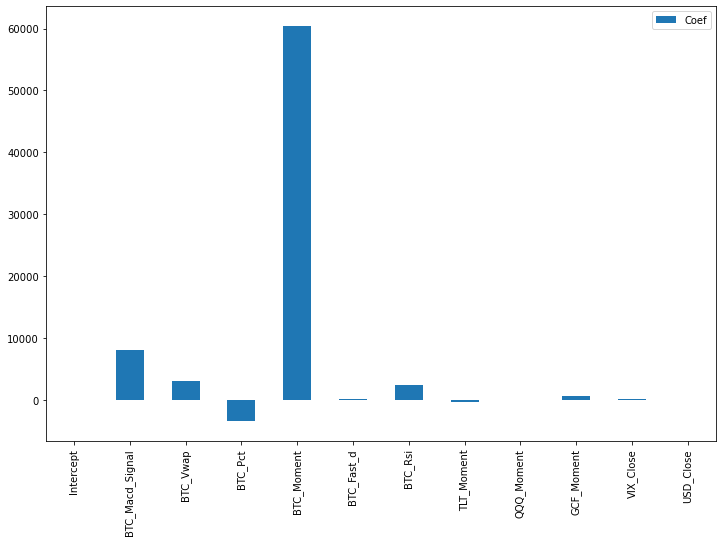

In [32]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns,True)

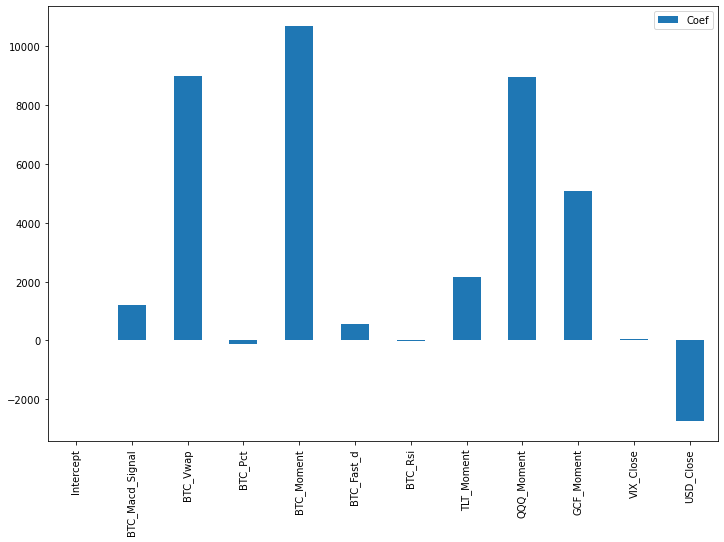

In [33]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)


In [36]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1,0.1,0.03,0.01,0.001]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha

ridge_model.set_params(poly_features__degree=3)
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

lasso_model.set_params(poly_features__degree=3)
l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

elastic_model.set_params(poly_features__degree=3)
e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



mse: 16695710.777460648, alpha: 1000
mse: 6911626.454413424, alpha: 300
mse: 3654337.3401636914, alpha: 100
mse: 2009621.9750002674, alpha: 30
mse: 1143339.0952224096, alpha: 10
mse: 478716.19895309926, alpha: 1
mse: 469821.6921215143, alpha: 0.1
mse: 477104.138136367, alpha: 0.03
mse: 482476.8742093011, alpha: 0.01
mse: 487891.96229228977, alpha: 0.001
mse: 17278254.733166512, alpha: 1000
mse: 3465879.417585232, alpha: 300
mse: 1190732.8392230913, alpha: 100
mse: 845857.691083185, alpha: 30
mse: 581052.7070344565, alpha: 10


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142995470.48078042, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122093325.0102967, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 449730.0123574057, alpha: 1
mse: 517915.99572341726, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166685273.5702176, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 562899.5599287042, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177741331.5464536, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 584116.084064531, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181413290.31272393, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142995470.48078042, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 601018.6674785245, alpha: 0.001
mse: 281243026.3124261, alpha: 1000
mse: 247356441.2377483, alpha: 300
mse: 180180478.20804572, alpha: 100
mse: 86052232.5190411, alpha: 30
mse: 33403776.17062509, alpha: 10
mse: 5774877.601571927, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2214010266.9663134, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 1682257.519627924, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280697853.1390157, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 904966.056665092, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 786279571.9664807, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 604144.6214439126, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363048320.2083647, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


mse: 442708.05657461344, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363048320.2083647, tolerance: 32723447.996811252
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=42))])

In [37]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [38]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)


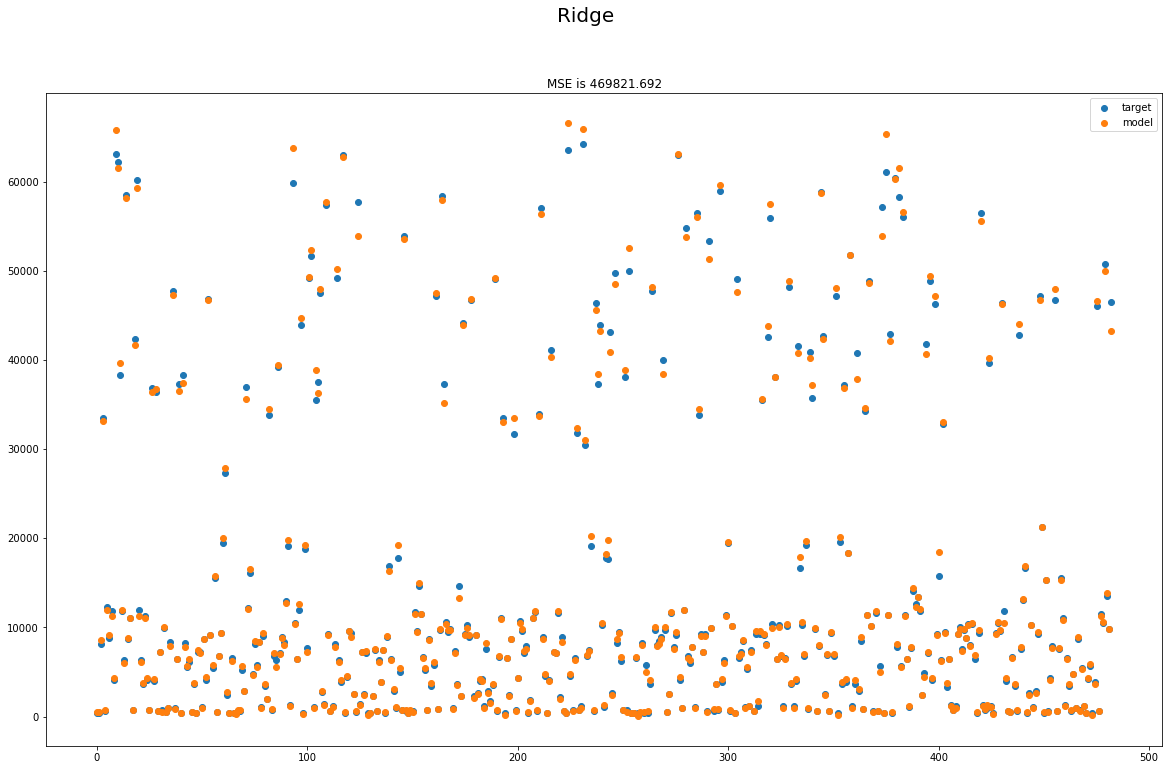

In [39]:
visualize(r_pred, test_y, "Ridge")

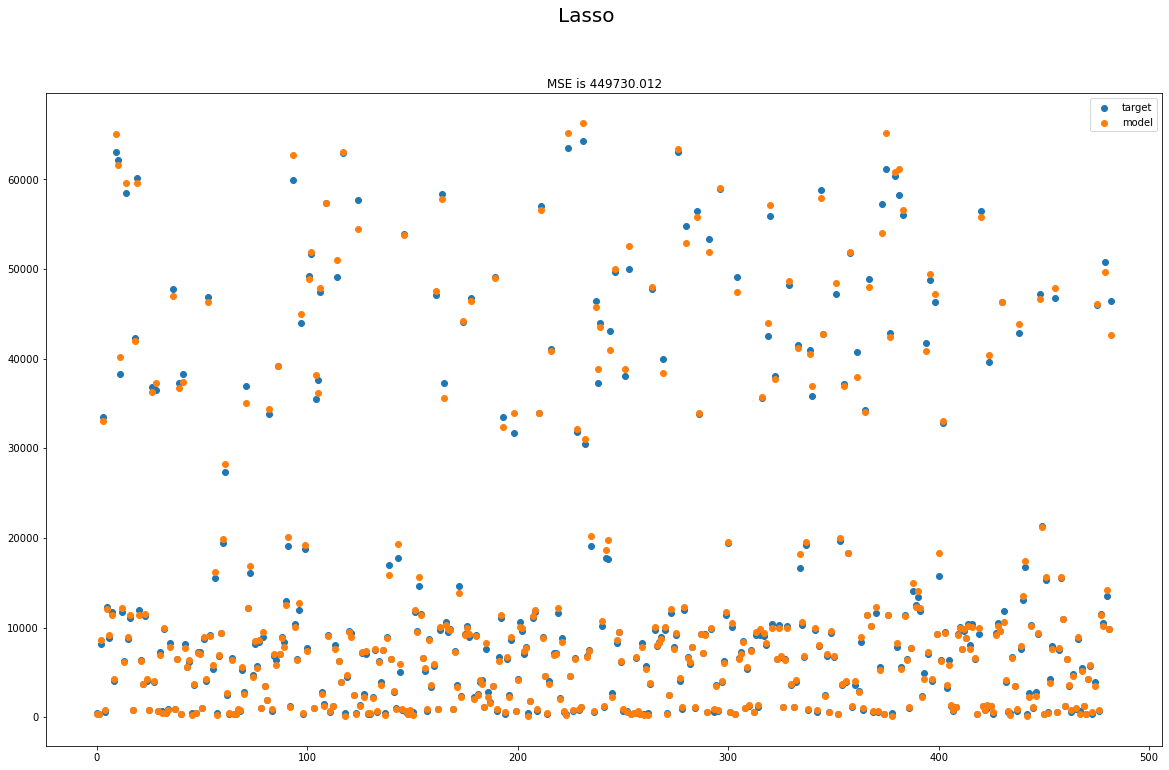

In [40]:
visualize(l_pred, test_y, "Lasso")


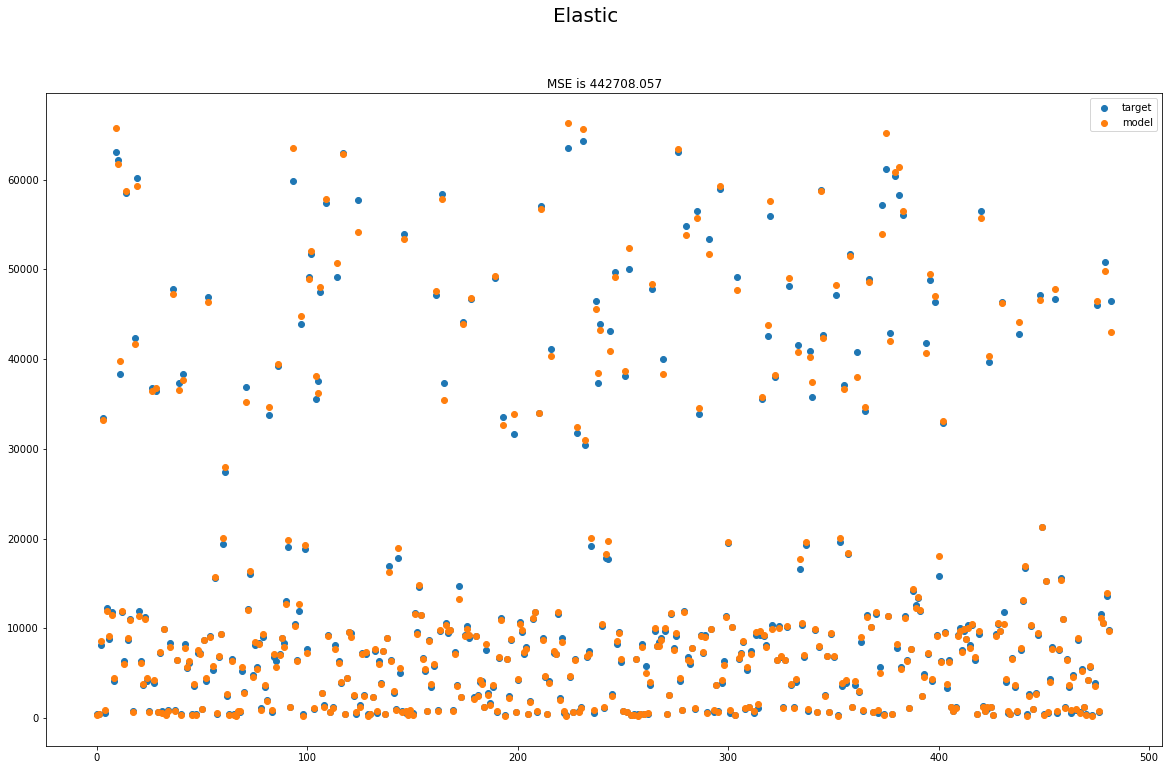

In [41]:
visualize(e_pred, test_y, "Elastic")

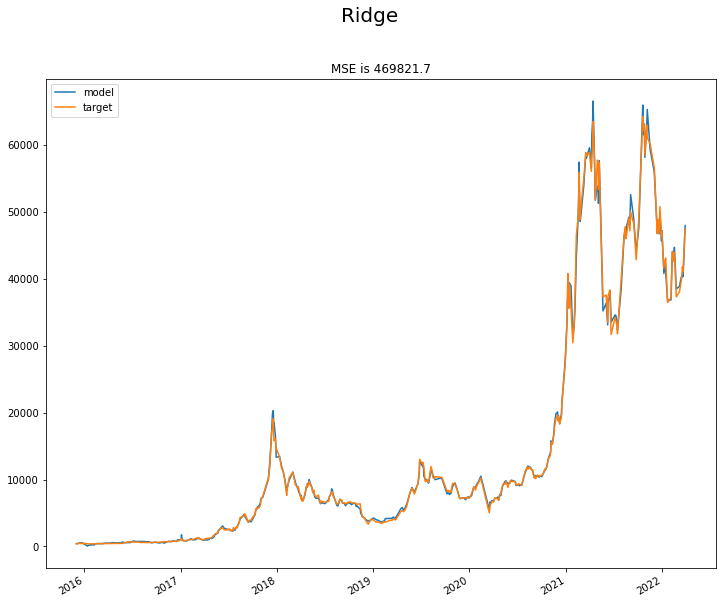

In [42]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


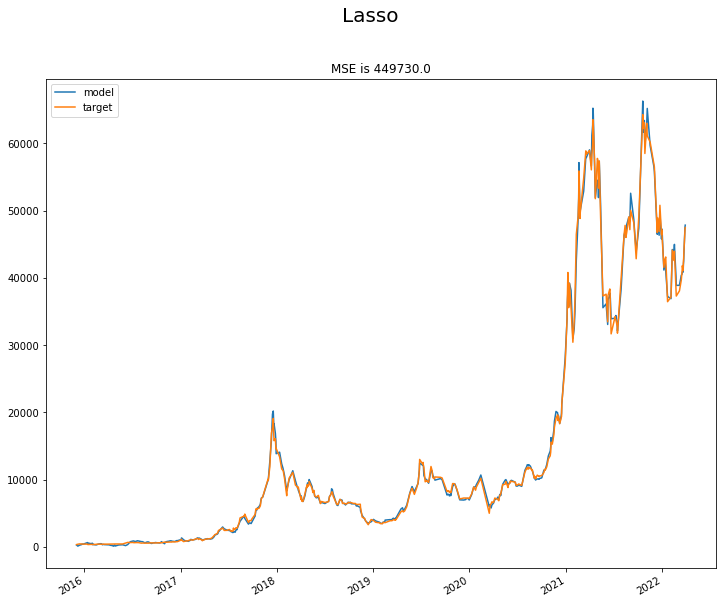

In [43]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")


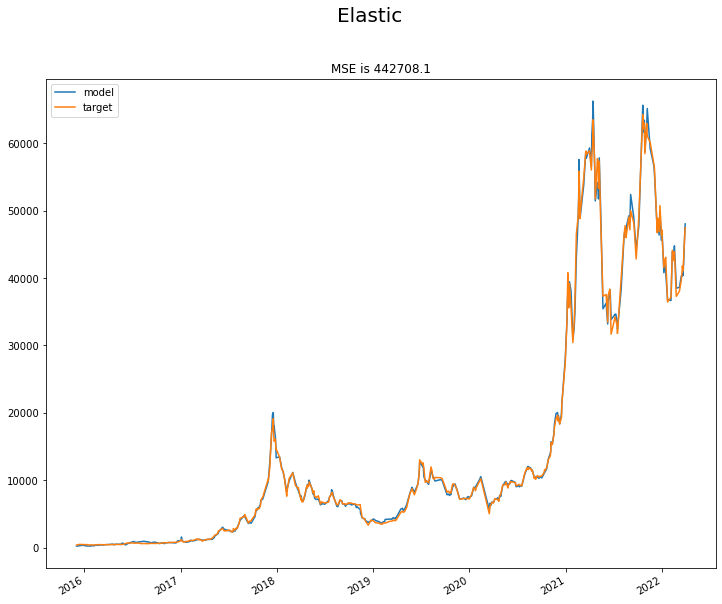

In [44]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df_merged.drop(['BTC_Price'], axis=1).iloc[1:]
train_y = df_merged['BTC_Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        result.append([mae, mse, score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score"]))

In [46]:
cv_result[0]

,mae,mse,score
0,31.461455,47.743117,0.788301
1,47.856438,52.330074,-1.686422
2,59.310744,68.993712,0.662790
3,150.695107,196.242090,0.818434
4,278.979768,377.920337,0.777947
5,4177.615775,8641.680634,-2.276325
6,1483.233507,1785.214054,-0.433286
7,391.234107,471.008578,0.736233
8,306.644644,440.846440,0.805752
9,422.379213,439.837263,-2.872668


In [47]:
cv_result[1]

,mae,mse,score
0,25.795125,36.013794,0.879542
1,20.121307,23.308375,0.467039
2,43.197555,50.243079,0.821173
3,117.217760,192.001663,0.826196
4,114.772253,163.313519,0.958533
5,536.036928,855.978999,0.967855
6,2785.795047,2940.971949,-2.889860
7,389.304031,512.356683,0.687890
8,163.375180,220.732470,0.951302
9,447.849216,477.895288,-3.571847


In [48]:
cv_result[2]

,mae,mse,score
0,36.286291,55.919266,0.709584
1,63.770742,69.919183,-3.795835
2,54.515121,63.581323,0.713621
3,106.345470,128.962929,0.921589
4,462.051572,631.986827,0.379028
5,6765.218966,12577.489227,-5.940304
6,1964.138576,2127.352351,-1.035313
7,369.775857,443.161032,0.766501
8,287.660167,427.860215,0.817027
9,272.243335,302.937797,-0.837101


In [49]:
for name, cv in zip(["Ridge","Lasso","Elastic"], cv_result):
    print(f"{name}:\n {cv.mean()}")

Ridge:
 mae      1548.451682
mse      2117.776173
score       0.065916
dtype: float64
Lasso:
 mae      1039.413190
mse      1235.659816
score       0.379148
dtype: float64
Elastic:
 mae      1554.975672
mse      2133.786570
score      -0.063985
dtype: float64


라쏘 모델의 퍼포먼스가 가장 괜찮게 나왔다. </br>
또한 라쏘는 대부분의 피쳐에 가중치를 0으로 취급하고</br>
비트코인의 속성 만을 활용해 측정하고 있다. 따라서 새로운 자산을 추가하는 것이 </br>
그다지 큰 효과를 발휘하고 있지 않다는 생각이 든다.
* 이는 아마 주식 데이터는 평일에만 열리게 되므로 주말 간의 데이터가 손실 된 것이 어느정도 기여를 하지 않나 싶다.

In [50]:
import joblib
joblib.dump(lasso_model, "Lasso_total.pkl")
joblib.dump(ridge_model, "Ridge_total.pkl")

['Ridge_total.pkl']